<a href="https://colab.research.google.com/github/aksoym/MyCodes/blob/master/AksoyMProject_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UUM625 Project 2
##ESTIMATION OF THE TOTAL FUEL FLOW RATE OF A JET AIRCRAFT USING DEEP REGRESSION MODELS

###A template is used as the core structure of the following code. Template is provided by Mevlüt Uzun in the course UUM625 at ITU.

####Prepared by Muhammet Aksoy

**Using the provided template to mount the drive and install libraries**

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130963 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.6-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.6-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!pip install imbalanced-learn
!pip install livelossplot
!pip install -U scikit-learn
!pip install joblib

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.21.2)


In [0]:
# Keras Libraries
from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras import backend as k
from keras.utils import multi_gpu_model
import tensorflow as tf
import random as rn
import os
import scipy.io as sio

# Pandas Libraries
import pandas as pd

# Numpy Libraries
import numpy as np
np.random.seed(27)

# File IO Libraries
import glob
import scipy.io as sio

# Plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

# Data Preparation Libraries
from sklearn import model_selection
from sklearn import preprocessing
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

os.environ['PYTHONHASHSEED'] = '0'

# Same pseudo-random number seed will be used everytime the code is run. This is to keep the things unchanged when the code is being run several times to re-evaluate.
np.random.seed(27)
rn.seed(27)
tf.set_random_seed(27)

sess = tf.Session(graph=tf.get_default_graph())
k.set_session(sess)

**Data Examination**

In [0]:
#Reading the datasets.
dataset_1 = pd.read_pickle("drive/DeepLearning/DataSet1")
dataset_2 = pd.read_pickle("drive/DeepLearning/DataSet2")

dataset_1

,Altitude (ft),Heading (deg),CAS (kt),Ground Speed (kt),Mach,Temp (C),Mass (kg),Apu Fuel (lb/hr),FF1 (lb/hr),FF2 (lb/hr),Throttle 1,Throttle 2,Course (deg),Wind Direction (deg),Wind Speed (kt),Flap (deg),Landing Gear,Speed Break,Zero Fuel Weight (lbs),Fuel Onboard (kg),Air Pressure (mb),Ground Speed Dot (kt/s2),Altitude Dot (ft/s),Heading Dot (deg/s),True Airspeed (m/s),True Airspeed Dot (m/s2),Gamma (rad),Drag (N),Thrust (N)
0,0.0,0.0,0.00,0.0,0.0000,0.00,0.000000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,139.0,263.0,130.13,121.0,0.1995,20.50,337140.125583,238.0,37264.0,36208.0,79.720,79.720,263.0,-97.0,10.63,15.0,1.0,0.0,507200.0,107100.0,1006.00,4.0,0.0,0.0,68.515987,1.874518,0.000000,492526.970794,1.124502e+06
2,139.0,263.0,132.88,125.0,0.2050,20.38,337130.850423,238.0,37184.0,36192.0,79.720,79.720,263.0,-96.0,9.50,15.0,1.0,0.0,507200.0,107050.0,1006.00,4.0,0.5,0.0,70.390504,2.139048,0.002165,468451.878186,1.196749e+06
3,140.0,263.0,137.13,129.0,0.2120,20.38,337121.585343,238.0,37168.0,36128.0,79.720,79.720,263.0,-94.0,9.00,15.0,1.0,0.0,507200.0,107000.0,1006.00,4.0,0.5,0.0,72.794083,2.309424,0.002094,441259.461999,1.226738e+06
4,140.0,263.0,143.00,133.0,0.2185,20.25,337112.316232,238.0,37184.0,36144.0,79.720,79.720,263.0,-95.0,11.38,15.0,1.0,0.0,507200.0,106950.0,1006.00,4.0,0.0,0.0,75.009352,1.794219,0.000000,419061.141494,1.023915e+06
5,140.0,263.0,146.63,137.0,0.2225,20.25,337103.039056,238.0,37216.0,36176.0,79.720,79.720,263.0,-96.0,11.25,15.0,1.0,0.0,507200.0,106900.0,1006.00,4.0,0.0,0.0,76.382521,1.888107,0.000000,406718.939987,1.043206e+06
6,140.0,263.0,149.38,141.0,0.2295,20.25,337093.761881,238.0,37200.0,36192.0,79.720,79.720,263.0,-96.0,10.13,15.0,1.0,0.0,507200.0,106850.0,1006.00,4.0,0.5,0.0,78.785567,2.059753,0.001934,387340.472605,1.088065e+06
7,141.0,263.0,152.25,145.0,0.2345,20.25,337084.480673,238.0,37232.0,36192.0,79.760,79.720,263.0,-98.0,9.88,15.0,1.0,0.0,507200.0,106800.0,1006.00,4.0,1.0,0.0,80.502028,1.716461,0.003786,375079.085241,9.661876e+05
8,142.0,263.0,158.00,149.0,0.2395,20.25,337075.201482,238.0,37248.0,36160.0,79.760,79.720,263.0,-100.0,11.50,15.0,1.0,0.0,507200.0,106750.0,1006.00,3.5,1.0,0.0,82.218489,1.536263,0.003707,364017.387243,8.941078e+05
9,143.0,263.0,159.63,152.0,0.2435,20.13,337065.938418,238.0,37184.0,36096.0,79.760,79.720,263.0,-99.0,10.13,15.0,1.0,0.0,507200.0,106700.0,1006.00,3.5,1.0,0.0,83.574553,1.373169,0.003647,355970.850501,8.308746e+05


In [0]:
dataset_2

,Altitude (ft),Heading (deg),CAS (kt),Ground Speed (kt),Mach,Temp (C),Mass (kg),Apu Fuel (lb/hr),FF1 (lb/hr),FF2 (lb/hr),Throttle 1,Throttle 2,Course (deg),Wind Direction (deg),Wind Speed (kt),Flap (deg),Landing Gear,Speed Break,Zero Fuel Weight (lbs),Fuel Onboard (kg),Air Pressure (mb),Ground Speed Dot (kt/s2),Altitude Dot (ft/s),Heading Dot (deg/s),True Airspeed (m/s),True Airspeed Dot (m/s2),Gamma (rad),Drag (N),Thrust (N)
0,0.0,0.0,0.00,0.0,0.0000,0.00,0.000000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,140.0,263.0,131.63,125.0,0.2025,18.25,325554.611609,238.0,31984.0,32544.0,75.190,75.320,263.0,-93.0,8.13,15.0,1.0,1.0,476160.0,109700.0,1008.00,3.0,0.0,0.0,69.279215,2.551095,0.000000,485283.286925,1.315804e+06
2,140.0,263.0,136.63,128.0,0.2100,18.13,325546.449257,238.0,31968.0,32576.0,75.190,75.320,263.0,-92.0,9.38,15.0,1.0,1.0,476160.0,109700.0,1008.00,3.5,0.0,0.0,71.830310,2.301695,0.000000,460186.379745,1.209495e+06
3,140.0,263.0,140.88,132.0,0.2160,18.13,325538.294968,238.0,31952.0,32528.0,75.190,75.320,263.0,-93.0,9.88,15.0,1.0,1.0,476160.0,109700.0,1008.00,4.0,0.0,0.0,73.882604,1.033760,0.000000,442943.004492,7.794714e+05
4,140.0,263.0,142.38,136.0,0.2160,18.25,325530.138664,238.0,31984.0,32512.0,75.230,75.320,263.0,-92.0,8.25,15.0,1.0,1.0,476160.0,109675.0,1008.00,3.5,0.0,0.0,73.897830,1.539221,0.000000,442924.664781,9.439875e+05
5,140.0,263.0,147.50,139.0,0.2250,18.13,325521.992440,238.0,32000.0,32416.0,75.230,75.320,263.0,-95.0,9.13,15.0,1.0,1.0,476160.0,109650.0,1008.00,3.5,0.5,0.0,76.961046,2.643268,0.001980,421236.636058,1.288000e+06
6,141.0,263.0,151.50,143.0,0.2315,18.13,325513.838152,238.0,32000.0,32480.0,75.230,75.320,263.0,-96.0,10.00,15.0,1.0,1.0,476160.0,109625.0,1008.00,4.0,1.0,0.0,79.184365,1.966782,0.003849,408345.044278,1.060847e+06
7,142.0,263.0,155.38,147.0,0.2365,18.13,325505.683863,238.0,31984.0,32496.0,75.230,75.320,263.0,-96.0,9.88,15.0,1.0,1.0,476160.0,109600.0,1008.00,3.5,0.5,0.0,80.894611,1.444543,0.001884,399846.254810,8.760671e+05
8,142.0,263.0,156.50,150.0,0.2400,18.00,325497.521511,238.0,31984.0,32560.0,75.230,75.320,263.0,-94.0,8.13,15.0,1.0,1.0,476160.0,109575.0,1008.00,3.0,0.5,0.0,82.073452,1.539221,0.001857,394570.140748,9.015100e+05
9,143.0,263.0,160.13,153.0,0.2455,18.13,325489.363191,238.0,32000.0,32512.0,75.230,75.320,263.0,-91.0,7.50,15.0,1.0,1.0,476160.0,109550.0,1008.00,3.5,0.5,0.0,83.973053,2.070341,0.001815,387354.803849,1.067022e+06


In [0]:
#Checking to see if there is any missing value.
print (dataset_1.isnull().values.any(), dataset_2.isnull().values.any(), sep="\n")
#Getting rid of the empty rows.
dataset_1 = dataset_1[dataset_1["Mass (kg)"] != 0]
dataset_2 = dataset_2[dataset_2["Mass (kg)"] != 0]
dataset_2.shape #There was only 1 empty row.

False
False


(375378, 29)

**Visualization**

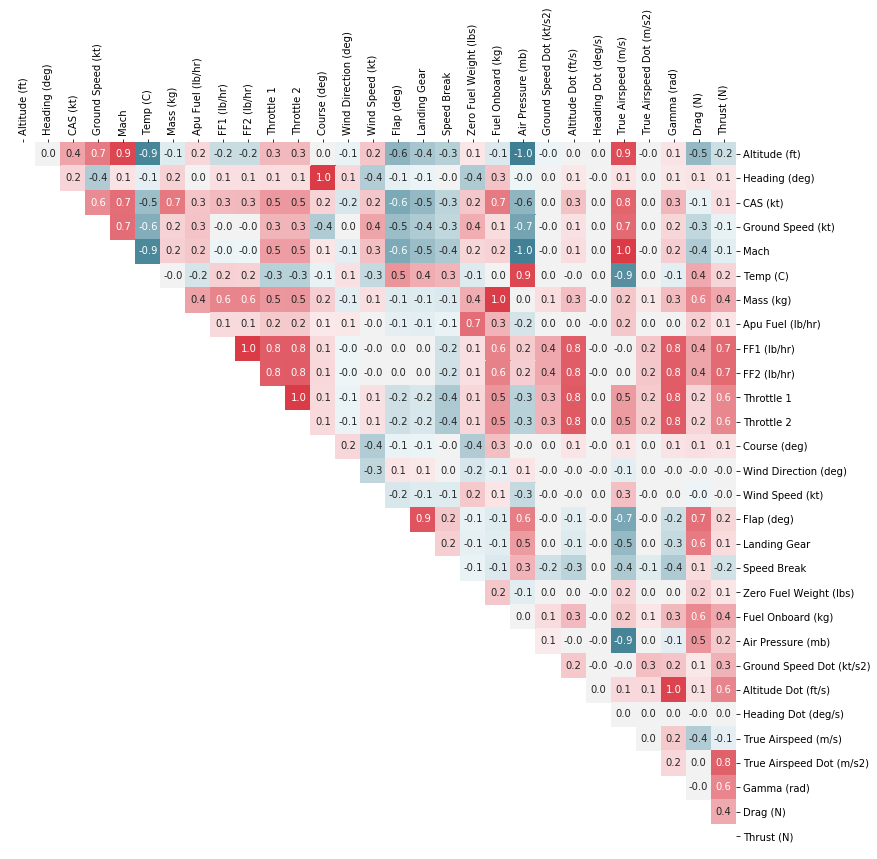

In [0]:
#Correlation matrix for DataSet1.    
cm = dataset_1.corr()
fig, ax = plt.subplots(figsize=(13, 13))
dropSelf = np.zeros_like(cm)
dropSelf[np.tril_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
plt.xticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
plt.yticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
sns.heatmap(cm, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf, cbar=False)
plt.show()

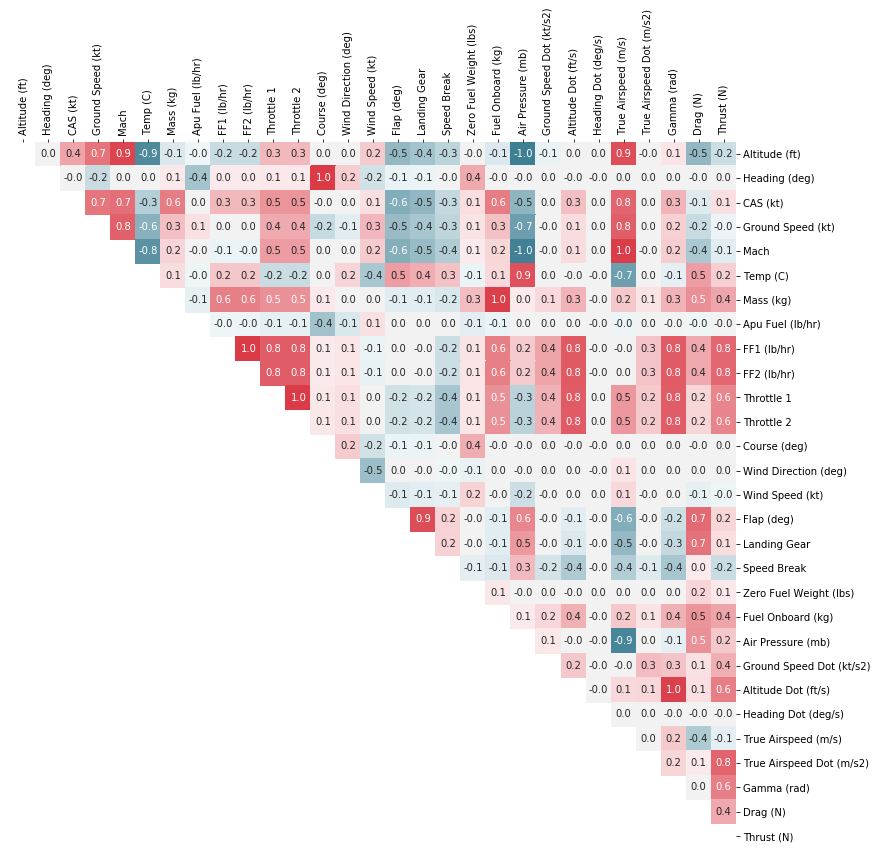

In [0]:
#Correlation matrix for DataSet2.    
cm = dataset_2.corr()
fig, ax = plt.subplots(figsize=(13, 13))
dropSelf = np.zeros_like(cm)
dropSelf[np.tril_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
plt.xticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
plt.yticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
sns.heatmap(cm, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf, cbar=False)
plt.show()

**Preperation of dataset_1**

In [0]:
#Converting FF1 and FF2 to kg/s and to Total-Fuel-Flow.
dataset_1['TFF (kg/s)'] = ((dataset_1['FF1 (lb/hr)'] + dataset_1['FF2 (lb/hr)'])/(7936.641))
 

#First stage; 6 features to 1 target.
x_features1 = np.column_stack( (dataset_1['Throttle 1'], dataset_1['Throttle 2'], dataset_1['Gamma (rad)'], dataset_1['Altitude Dot (ft/s)'], dataset_1['Thrust (N)'], dataset_1["Mass (kg)"]) )
#Second stage; dropping throttle positions.
x_features2 = np.column_stack( (dataset_1['Gamma (rad)'], dataset_1['Altitude Dot (ft/s)'], dataset_1['Thrust (N)'], dataset_1["Mass (kg)"]) )
#Third stage; finding proper features to replace throttle positions. Adding "Drag", "True Airspeed Dot" and "Fuel Onboard (kg)".
x_features3 = np.column_stack( (dataset_1['Drag (N)'], dataset_1['True Airspeed Dot (m/s2)'], dataset_1['Gamma (rad)'], dataset_1['Altitude Dot (ft/s)'],
                                dataset_1['Thrust (N)'], dataset_1["Mass (kg)"], dataset_1["Fuel Onboard (kg)"]) )

# Target array for the first 3 stages.(kg/s).
y_target = np.array(dataset_1["TFF (kg/s)"])
y_target = y_target.reshape(-1, 1)  
  

#Fourth stage; splitting datasets to climb, cruise and descent phases.
climb_phase = dataset_1[dataset_1['Altitude Dot (ft/s)'] > 0]
cruise_phase = dataset_1[dataset_1['Altitude Dot (ft/s)'] == 0]
descent_phase = dataset_1[dataset_1['Altitude Dot (ft/s)'] < 0]

x_features4 = np.column_stack( (climb_phase['Throttle 1'], climb_phase['Throttle 2'], climb_phase['Gamma (rad)'], climb_phase['Altitude Dot (ft/s)'], climb_phase['Thrust (N)'], climb_phase["Mass (kg)"]) )

x_features5 = np.column_stack( (cruise_phase['Throttle 1'], cruise_phase['Throttle 2'], cruise_phase['Gamma (rad)'], cruise_phase['Altitude Dot (ft/s)'], cruise_phase['Thrust (N)'], cruise_phase["Mass (kg)"]) )

x_features6 = np.column_stack( (descent_phase['Throttle 1'], descent_phase['Throttle 2'], descent_phase['Gamma (rad)'], descent_phase['Altitude Dot (ft/s)'], descent_phase['Thrust (N)'], descent_phase["Mass (kg)"]) )

#Fourth stage target arrays.
y_target4 = np.array(climb_phase["TFF (kg/s)"])
y_target4 = y_target4.reshape(-1, 1)

y_target5 = np.array(cruise_phase["TFF (kg/s)"])
y_target5 = y_target5.reshape(-1, 1)

y_target6 = np.array(descent_phase["TFF (kg/s)"])
y_target6 = y_target6.reshape(-1, 1)



**Preparation of dataset_2**

In [0]:
#Converting FF1 and FF2 to kg/s and to Total-Fuel-Flow.
dataset_2['TFF (kg/s)'] = ((dataset_2['FF1 (lb/hr)'] + dataset_2['FF2 (lb/hr)'])/(7936.641))
 

#First stage; 6 features to 1 target.
ds2_features1 = np.column_stack( (dataset_2['Throttle 1'], dataset_2['Throttle 2'], dataset_2['Gamma (rad)'], dataset_2['Altitude Dot (ft/s)'], dataset_2['Thrust (N)'], dataset_2["Mass (kg)"]) )
#Second stage; dropping throttle positions.
ds2_features2 = np.column_stack( (dataset_2['Gamma (rad)'], dataset_2['Altitude Dot (ft/s)'], dataset_2['Thrust (N)'], dataset_2["Mass (kg)"]) )
#Third stage; finding proper features to replace throttle positions. Adding "Drag", "True Airspeed Dot" and "Fuel Onboard (kg)".
ds2_features3 = np.column_stack( (dataset_2['Drag (N)'], dataset_2['True Airspeed Dot (m/s2)'], dataset_2['Gamma (rad)'], dataset_2['Altitude Dot (ft/s)'],
                                dataset_2['Thrust (N)'], dataset_2["Mass (kg)"], dataset_2["Fuel Onboard (kg)"]) )

# Target array for the first 3 stages.(kg/s).
ds2_target = np.array(dataset_2["TFF (kg/s)"])
ds2_target = ds2_target.reshape(-1, 1)  
  

#Fourth stage; splitting datasets to climb, cruise and descent phases.
climb_phase = dataset_2[dataset_2['Altitude Dot (ft/s)'] > 0]
cruise_phase = dataset_2[dataset_2['Altitude Dot (ft/s)'] == 0]
descent_phase = dataset_2[dataset_2['Altitude Dot (ft/s)'] < 0]

ds2_features4 = np.column_stack( (climb_phase['Throttle 1'], climb_phase['Throttle 2'], climb_phase['Gamma (rad)'], climb_phase['Altitude Dot (ft/s)'], climb_phase['Thrust (N)'], climb_phase["Mass (kg)"]) )

ds2_features5 = np.column_stack( (cruise_phase['Throttle 1'], cruise_phase['Throttle 2'], cruise_phase['Gamma (rad)'], cruise_phase['Altitude Dot (ft/s)'], cruise_phase['Thrust (N)'], cruise_phase["Mass (kg)"]) )

ds2_features6 = np.column_stack( (descent_phase['Throttle 1'], descent_phase['Throttle 2'], descent_phase['Gamma (rad)'], descent_phase['Altitude Dot (ft/s)'], descent_phase['Thrust (N)'], descent_phase["Mass (kg)"]) )

#Fourth stage target arrays.
ds2_target4 = np.array(climb_phase["TFF (kg/s)"])
ds2_target4 = ds2_target4.reshape(-1, 1)

ds2_target5 = np.array(cruise_phase["TFF (kg/s)"])
ds2_target5 = ds2_target5.reshape(-1, 1)

ds2_target6 = np.array(descent_phase["TFF (kg/s)"])
ds2_target6 = ds2_target6.reshape(-1, 1)

**Train - Test Split**

In [0]:
#Splitting the dataset.
X_train, X_test, y_train, y_test = train_test_split(ds2_features6, ds2_target6, test_size=0.2, shuffle=True)

#Choosing the scaler.
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.StandardScaler()

#Scaling the values.
sc1 = scaler1.fit( X_train )
x_train_sc = sc1.transform( X_train )
x_test_sc = sc1.transform( X_test )
           
sc2 = scaler2.fit( y_train )
y_train_sc = sc2.transform( y_train )
y_test_sc = sc2.transform( y_test )
             

**Architecture of the Network**

In [0]:
k.clear_session() # Keep this line of code here to reset your networks parameters.

# The number of inputs (features) on our input layer.
n_dims = X_train.shape[1]

# Defining the input layer with the shape n_dims.
aircraft_measurements = Input(shape=(n_dims,))

# Hidden layers.
L1 = Dense(1024, activation="relu",
         kernel_initializer= "glorot_uniform", bias_initializer="zeros")(aircraft_measurements)
L2 = Dense(1024, activation="relu",
          kernel_initializer="glorot_uniform", bias_initializer="zeros")(L1)
L3 = Dense(1024, activation="relu",
          kernel_initializer= "glorot_uniform", bias_initializer="zeros")(L2)




# Defining the output layer. Shape = number of targets.
fuel_flow = Dense(y_train_sc.shape[1], kernel_initializer="random_uniform")(L3)

# State input and output layers. The model will connect the necessary layers accordingly.
model = Model(inputs=[aircraft_measurements], outputs=[fuel_flow])

# Selection of optimizer and loss function.
model.compile(optimizer="adam", loss="mean_squared_error" )

# Create a filename for your best model
model_name = 'my_model.hdf5'

path="drive/DeepLearning/" + model_name
checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, period=1, mode='min')

**Model Training**

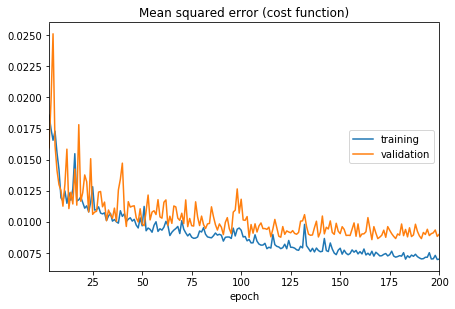

Mean squared error (cost function):
training   (min:    0.007, max:    0.048, cur:    0.007)
validation (min:    0.009, max:    0.025, cur:    0.009)

Epoch 00200: loss did not improve from 0.00697


In [0]:
num_epochs = 200
batch_size = 512
validation_size = 0.2

history = model.fit(x_train_sc, y_train_sc, 
                    batch_size=batch_size, epochs=num_epochs, shuffle=True, 
                    validation_split=validation_size, callbacks=[PlotLossesKeras(), checkpoint])

In [0]:
# Load the model with best results
model = load_model(path)

# Make the prediction
y_predicted = model.predict(x_test_sc)

# Take inverse transform of your prediction (because it is scaled!)
y_predicted_inv = sc2.inverse_transform( y_predicted )

In [0]:
mae = str(np.round(mean_absolute_error(y_predicted_inv, y_test), 4))
print("Mean absolute error is :  " + mae + " (kg/s)")

Mean absolute error is :  0.0422 (kg/s)
